In [1]:
from aspire.source import Simulation
from aspire.basis import FSPCABasis
from aspire.volume import Volume
import logging
from aspire.noise import AnisotropicNoiseEstimator, CustomNoiseAdder
from aspire.operators import FunctionFilter, RadialCTFFilter
import numpy as np
logger = logging.getLogger(__name__)

interactive = True  # Draw blocking interactive plots?
do_cov2d = False  # Use CWF coefficients
img_size = 32  # Downsample the volume to a desired resolution
num_imgs = 10000  # How many images in our source.
n_classes = 1000  # How many class averages to compute.
n_nbor = 10  # How many neighbors to stack
noise_variance = 5e-7  # Set a target noise variance

og_v = Volume.load("map-data/emd_14930.map.gz", dtype=np.float64)
v = og_v.downsample(img_size)
L = v.resolution
def noise_function(x, y):
    alpha = 1
    beta = 1
    # White
    f1 = noise_variance
    # Violet-ish
    f2 = noise_variance * (x * x + y * y) / L * L
    return (alpha * f1 + beta * f2) / 2.0
custom_noise = CustomNoiseAdder(noise_filter=FunctionFilter(noise_function))
pixel_size = 5 * 65 / img_size  # Pixel size of the images (in angstroms)
voltage = 200  # Voltage (in KV)
defocus_min = 1.5e4  # Minimum defocus value (in angstroms)
defocus_max = 2.5e4  # Maximum defocus value (in angstroms)
defocus_ct = 7  # Number of defocus groups.
Cs = 2.0  # Spherical aberration
alpha = 0.1  # Amplitude contrast
ctf_filters = [
    RadialCTFFilter(pixel_size, voltage, defocus=d, Cs=2.0, alpha=0.1)
    for d in np.linspace(defocus_min, defocus_max, defocus_ct)
]

# Finally create the Simulation
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    noise_adder=custom_noise,
    unique_filters=ctf_filters,
    dtype=v.dtype,
)


src.phase_flip()
aiso_noise_estimator = AnisotropicNoiseEstimator(src)
src.whiten(aiso_noise_estimator.filter)

2023-03-06 19:05:46,069 INFO [aspire.volume.volume] map-data/emd_14930.map.gz with dtype float32 loaded as <class 'numpy.float64'>
2023-03-06 19:05:54,015 INFO [aspire.source.image] Creating Simulation with 10000 images.
2023-03-06 19:05:54,073 INFO [aspire.source.simulation] Appending CustomNoiseAdder to generation pipeline
2023-03-06 19:05:54,077 INFO [aspire.source.image] Perform phase flip on source object
2023-03-06 19:05:54,078 INFO [aspire.source.image] Adding Phase Flip Xform to end of generation pipeline


  0%|          | 0/20 [00:00<?, ?it/s]

2023-03-06 19:05:54,109 INFO [aspire.nufft] Trying NFFT backend cufinufft
2023-03-06 19:05:54,113 INFO [aspire.nufft] NFFT backend cufinufft not usable:
	No module named 'pycuda'
2023-03-06 19:05:54,114 INFO [aspire.nufft] Trying NFFT backend finufft
2023-03-06 19:05:54,134 INFO [aspire.nufft] NFFT backend finufft usable.
2023-03-06 19:05:54,135 INFO [aspire.nufft] Trying NFFT backend pynfft
2023-03-06 19:05:54,137 INFO [aspire.nufft] NFFT backend pynfft not usable:
	No module named 'pynfft'
2023-03-06 19:05:54,139 INFO [aspire.nufft] Selected NFFT backend = finufft.


100%|██████████| 20/20 [00:26<00:00,  1.34s/it]

2023-03-06 19:06:20,972 INFO [aspire.source.image] Whitening source object
2023-03-06 19:06:20,973 INFO [aspire.source.image] Transforming all CTF Filters into Multiplicative Filters
2023-03-06 19:06:20,975 INFO [aspire.source.image] Adding Whitening Filter Xform to end of generation pipeline


In [2]:
basis = FSPCABasis(src = src, components=400, batch_size=512)


2023-03-06 19:06:21,061 INFO [aspire.basis.ffb_2d] Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.
2023-03-06 19:06:21,125 INFO [aspire.basis.fspca] Estimating the noise of images.
2023-03-06 19:06:21,126 INFO [aspire.noise.noise] Determining Noise variance in batches of 512


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]

2023-03-06 19:06:46,500 INFO [aspire.noise.noise] Noise variance = 0.9657965548819362
2023-03-06 19:06:46,501 INFO [aspire.basis.fspca] Setting noise_var=0.9657965548819362
2023-03-06 19:06:46,503 INFO [aspire.covariance.covar2d] Represent CTF filters in FB basis


2023-03-06 19:07:17,712 WARNING [aspire.covariance.covar2d] Left side b after removing noise in Batched Cov2D is not positive semidefinite.
2023-03-06 19:07:18,032 WARNING [aspire.covariance.covar2d] Covariance matrix in Batched Cov2D is not positive semidefinite.
2023-03-06 19:07:18,034 INFO [aspire.covariance.covar2d] Convert matrices to positive semidefinite.


In [3]:
import torch
from scipy.spatial.transform import Rotation as sp_rot

sp_rotations = sp_rot.from_matrix(src.rotations)
rot_vecs = sp_rotations.as_rotvec()
rot_vecs /= np.linalg.norm(rot_vecs, axis=-1)[:,np.newaxis]
rot_vecs = torch.from_numpy(rot_vecs)
rot_vecs = torch.stack((rot_vecs,rot_vecs), dim=1).view(2*rot_vecs.shape[0],rot_vecs.shape[1])


coefs = basis.spca_coef
coefs = basis.to_complex(coefs)
coefs = torch.from_numpy(coefs)

In [4]:
rotvecs_inners = torch.matmul(rot_vecs, torch.transpose(rot_vecs,0,1))


In [5]:
from tqdm.notebook import tqdm

def max_filter_torch(Z, coefs, rotvecs_inners, basis, padding = 400):
    num_temp = Z.shape[0]
    num_pics = coefs.shape[0]
    matrix_result = torch.zeros(num_temp, num_pics*2)

    max_filter_bank = []
    max_filter_bank_refl = []

    for i in range(num_pics):
        output = basis.max_filter_bank(coefs[i].numpy(), Z, basis.max_filter_fft, padding)
        reg_out = torch.from_numpy(output[0]).view(num_temp,1)
        refl_out = torch.from_numpy(output[1]).view(num_temp,1)
        matrix_result[:,2*i] = reg_out
        matrix_result[:,2*i+1] = refl_out

    bank_inners = torch.matmul(torch.transpose(matrix_result), matrix_result)

    return torch.linalg.matrix_norm(bank_inners - rotvecs_inners)


num_templates = 40
lr = 0.1

indices = torch.randperm(len(coefs))[:num_templates]
coefs_copy = coefs.data.clone()
Z = coefs_copy[indices].requires_grad_(True)

optim = torch.optim.Adam([Z], lr = lr)

steps = 100
for s in tqdm(range(steps)):
  optim.zero_grad()
  W = max_filter_torch(Z, coefs, rotvecs_inners, basis, padding=400)
  W.backward()
  optim.step()


  0%|          | 0/100 [00:00<?, ?it/s]

: 

: 

### All Rot Vec Opt

In [ ]:
def max_filter_bank_torch(complex_coef, Z, basis, padding):
    num_temp = Z.shape[0]
    fixed_ang_indices = basis.fixed_angular_indices
    k_max = basis.k_max
    reflected_coef = complex_coef.clone()
    for k, k_indices in fixed_ang_indices.items():
        reflected_coef[k_indices] = torch.pow(torch.tensor(-1), k)*torch.conj(complex_coef[k_indices])

    result_reg = torch.zeros(num_temp)
    result_refl = torch.zeros(num_temp)
    for i in range(num_temp):
        template = Z[i]
        inner_with_zeros = torch.zeros(int(k_max) + padding + 1, dtype=torch.cfloat)
        for k, k_indices in fixed_ang_indices.items():
            zk = complex_coef[k_indices]
            wk = template[k_indices]
            inner_with_zeros[k] = torch.linalg.vecdot(zk,wk)
        inner_with_zeros_refl = torch.zeros(int(k_max) + padding + 1, dtype=torch.cfloat)
        for k, k_indices in fixed_ang_indices.items():
            zkr = reflected_coef[k_indices]
            wkr = template[k_indices]
            inner_with_zeros_refl[k] = torch.linalg.vecdot(zkr,wkr)
        
        transformed_inner = torch.fft.fft(inner_with_zeros)
        transformed_inner_refl = torch.fft.fft(inner_with_zeros_refl)
        real_part = torch.max(torch.real(transformed_inner))
        real_part_refl = torch.max(torch.real(transformed_inner_refl))
        
        result_reg[i] = real_part
        result_refl[i] = real_part_refl

    return torch.transpose(torch.stack((result_reg, result_refl), dim = 1),0,1)


In [ ]:
def max_filter_torch(Z, coefs, rotvecs_inners, basis, padding = 400):
    num_temp = Z.shape[0]
    num_pics = coefs.shape[0]
    matrix_result = torch.zeros(num_temp, num_pics*2)

    for i in range(num_pics):
        output = max_filter_bank_torch(coefs[i], Z, basis, padding)
        reg_out = torch.Tensor(output[0]).view(num_temp)
        refl_out = torch.Tensor(output[1]).view(num_temp)
        matrix_result[:,2*i] = reg_out
        matrix_result[:,2*i+1] = refl_out

    bank_inners = torch.matmul(torch.transpose(matrix_result,0,1), matrix_result)

    return torch.pow(torch.linalg.matrix_norm(bank_inners - rotvecs_inners),2)


In [ ]:
rotvecs_inners = torch.matmul(rot_vecs, torch.transpose(rot_vecs,0,1))

In [ ]:
from tqdm.notebook import tqdm
torch.set_grad_enabled(True)  

num_templates = 40
lr = 0.1

indices = torch.randperm(len(coefs))[:num_templates]
coefs_copy = coefs.data.clone()
#Z = coefs_copy[indices].requires_grad_(True)

#max_filter_torch(Z, coefs, rotvecs_inners, basis, padding=400)

#basis.max_filter_bank_fft(coefs[0].numpy(), Z.data.numpy(), 400)

optim = torch.optim.Adam([Z], lr = lr)

steps = 1000
Z_hist = [Z.data.clone()]
W_hist = []
Zgrad_hist = []
for s in tqdm(range(steps)):
  optim.zero_grad()
  W = max_filter_torch(Z, coefs, rotvecs_inners, basis, padding=400)
  W_hist.append(W.data.clone().numpy())
  #W.requires_grad = True
  W.backward()
  Zgrad_hist.append(Z.grad.clone())
  optim.step()
  Z_hist.append(Z.data.clone())


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

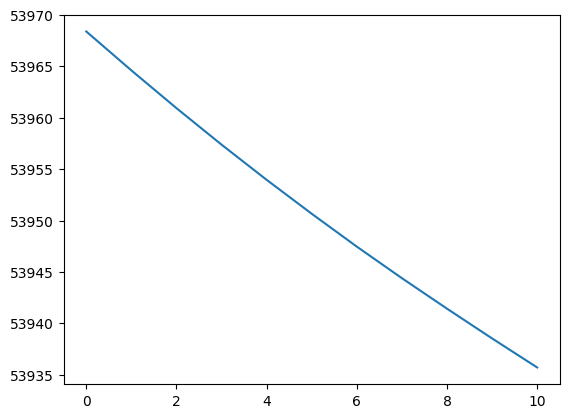

In [ ]:
import matplotlib.pyplot as plt
plt.plot(W_hist[120:])

In [ ]:
pre_complex = Z.data.numpy()
pre_real = basis.to_real(pre_complex)
after_eval = basis.evaluate_to_image_basis(pre_real).asnumpy()
from aspire.image import Image
im = Image(after_eval)
im.show()

# note that we only took 40 templates and 20 components and num images is 300 and vol is asymmetric gaussian

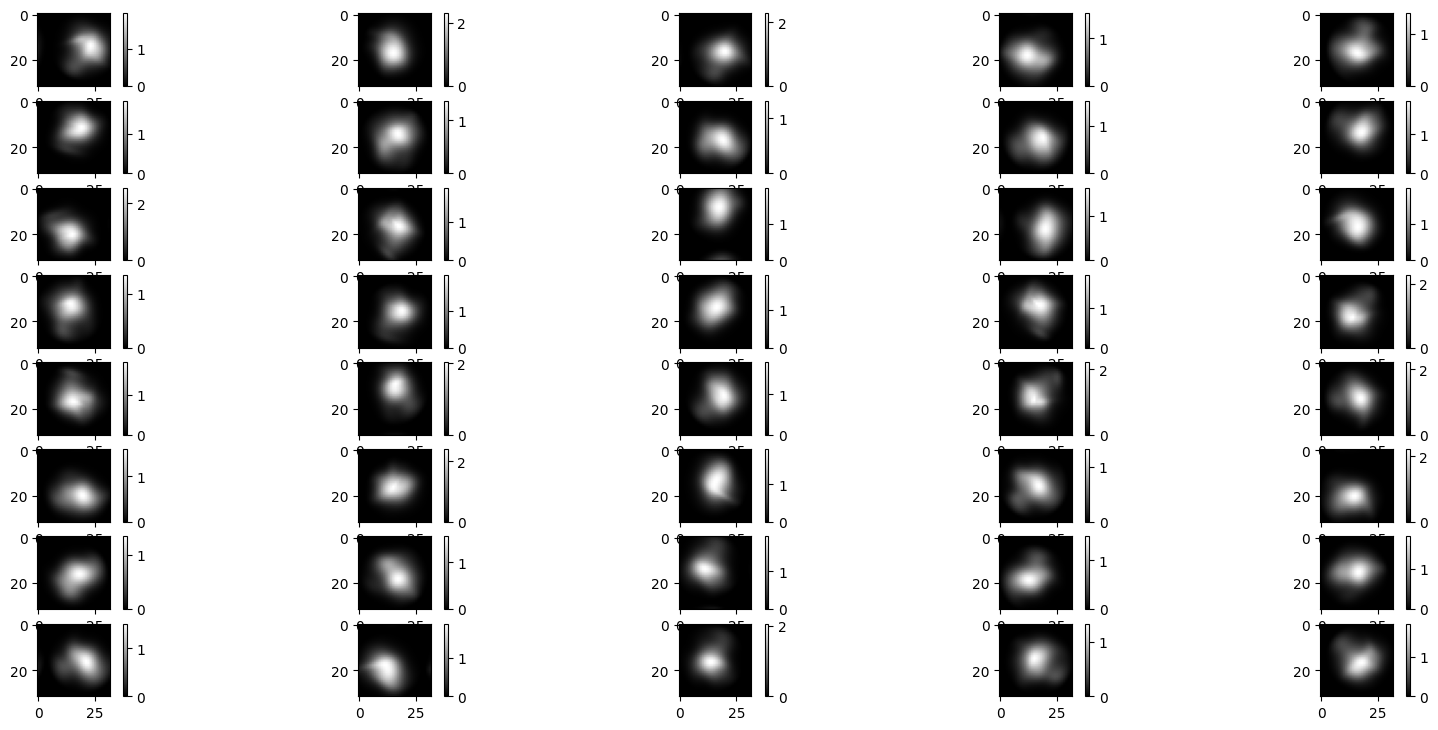

In [ ]:
src.images[indices].show()

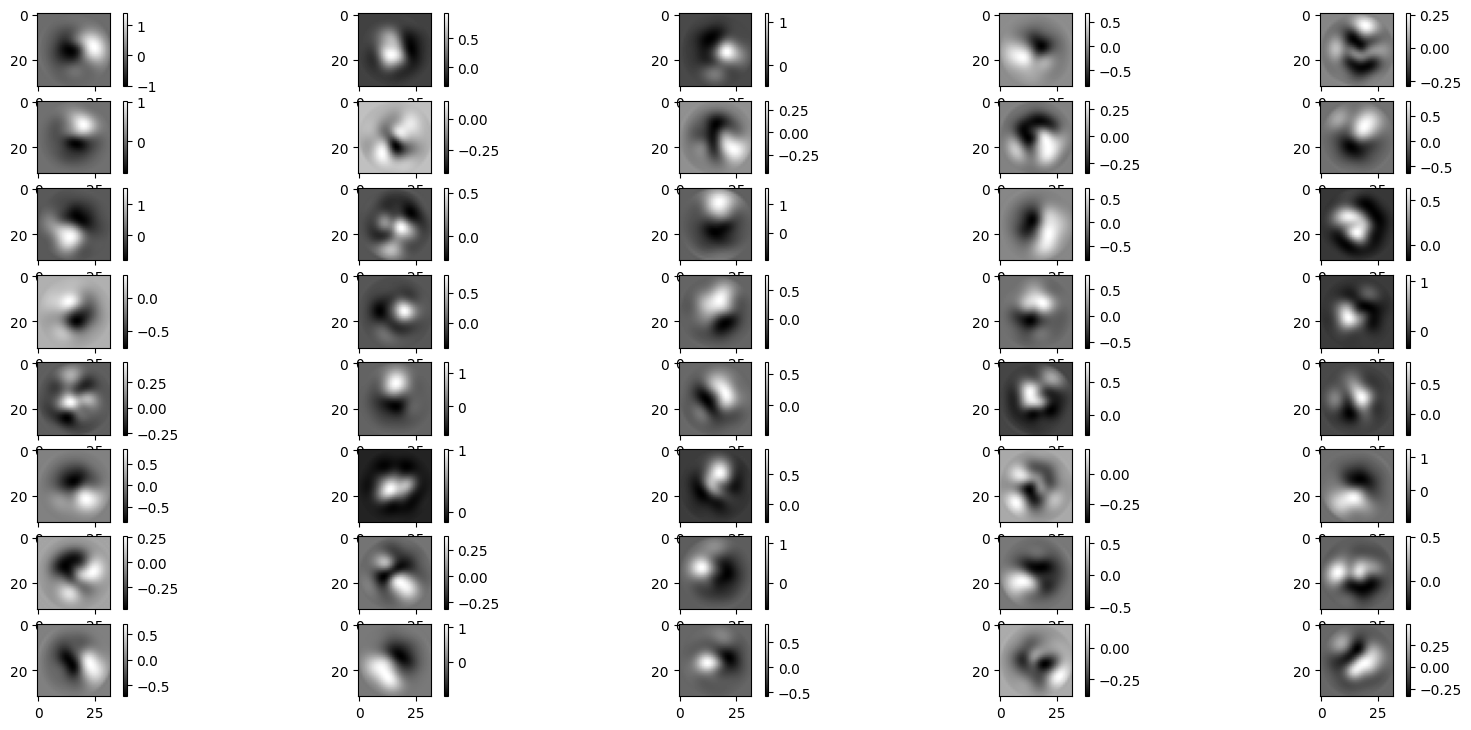

In [ ]:
after_pca_images_numpy = basis.evaluate_to_image_basis(basis.spca_coef).asnumpy()
after_pca_images = Image(after_pca_images_numpy[indices])
after_pca_images.show()